# Tutorial 3: Applying FDTD to Photonic Crystal Slab Simulation

In this tutorial, we show how to apply FDTD to solve a slightly more complicated EM problem involving a photonic crystal slab that supports guided resonance. In particular, we reproduce the findings of Shanhui et al. (2003), which is linked [here](https://opg.optica.org/josaa/abstract.cfm?uri=josaa-20-3-569).

For more details, refer to the [Tidy3d documentation](https://docs.simulation.cloud/projects/tidy3d/en/latest).

##  Setup

First we import Tidy3d and the other packages needed. If it is not installed, please do so with ``pip install tidy3d-beta``.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web

Next, let us define some key parameters.

In [2]:
runtime = 100.0 # in unit of 1/frequency bandwidth of the source
dPML = 1.0 # space between PhC slabs and PML, in unit of longest wavelength of interest

Let us define some basic parameters.

In [3]:
# Wavelength and frequency range
freq_range = (75e12, 135e12)
lambda_range = (td.constants.C_0/freq_range[1], td.constants.C_0/freq_range[0])
freq0 = np.sum(freq_range)/2

# central frequency, frequency pulse width
lambda0 = td.C_0 / freq0
width = 0.3
freqw  = width * (freq_range[1] - freq_range[0])

# runtime
t_stop = runtime/freqw    
print(f"Total runtime <= {t_stop*1e12} ps")

# frequencies and wavelengths of monitor
Nfreq = 1001
monitor_freqs = np.linspace(freq_range[0], freq_range[1], Nfreq)
monitor_lambdas = td.constants.C_0 / monitor_freqs

# PhC slab
period = 1.0 # um, period along x- and y- direction
t_slab = 0.55 # um, thickness
ep_slab = 12 # permittivity
mat_slab = td.Medium(permittivity=ep_slab)

# PhC air hole
radius = 0.2 # um, radius
ep_hole = 1 #permittivity
mat_hole = td.Medium(permittivity=ep_hole)

# Grid size # um
dl = lambda_range[0] / 30 / np.sqrt(ep_slab) # 30 grids per smallest wavelength in medium
print(f"dl = {dl*1000} nm")

# space between PhC slabs and PML
spacing = dPML * lambda_range[-1]

# simulation size
sim_size = Lx, Ly, Lz = (period, period, 2*spacing + t_slab)

Total runtime <= 5.555555555555555 ps
dl = 21.36855020527523 nm


## Create Simulation
Now we set everything else up (structures, sources, monitors, simulation) to run the example.

First, we define the unit cell of PhC, made of a high-index slab and an air hole.

In [4]:
slab = td.Structure(
    geometry=td.Box(
        center=(0, 0, 0),
        size=(td.inf,td.inf,t_slab),
    ),
    medium=mat_slab,
)

hole = td.Structure(
    geometry=td.Cylinder(
        center=(0, 0, 0),
        axis=2,
        radius=radius,
        length=t_slab,
    ),
    medium=mat_hole,
)

We must now define the excitation conditions and field monitors. We will excite the slab using a normally incident (along z) planewave, polarized along the x direciton.

In [5]:
# Here we define the planewave source, placed just in advance (towards negative z) of the slab
source = td.PlaneWave(
    source_time = td.GaussianPulse(
        freq0=freq0,
        fwidth=freqw
    ),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -Lz/2+spacing/2),
    direction='+',
    pol_angle=0,
)

Here we define the field monitor, placed past (towards positive z) of the PhC slab.

In [6]:
# We are interested in measuring the transmitted flux, so we set it to be an oversized plane.
monitor = td.FluxMonitor(
    center = (0, 0, Lz/2 - spacing/2),
    size = (td.inf, td.inf, 0),
    freqs = monitor_freqs,
    name='flux',
)

Additionally, we also place a time monitor in the middle of the field monitor plane to monitor the time evolution of the field.

In [7]:
# We are interested in measuring the time evolution at a single point in the field monitor plane
monitor_time = td.FieldTimeMonitor(
    center = (0, 0, Lz/2 - spacing/2),
    size = (0, 0, 0),
    fields = ['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz'],
    name='time',
)

Now it is time to define the simulation object.

In [8]:
sim = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    grid_spec = td.GridSpec.uniform(dl=dl),
    structures = [slab,hole],
    sources = [source],
    monitors = [monitor,monitor_time],
    run_time = t_stop,
    shutoff = 1e-7,
    pml_layers = (None, None, td.PML())
)

## Plot The Structure

Let's now plot the permittivity profile to confirm that the structure was defined correctly. We use the `Simulation.plot()` method to plot the materials only, which assigns a different color to each slab without knowledge of the material properties.

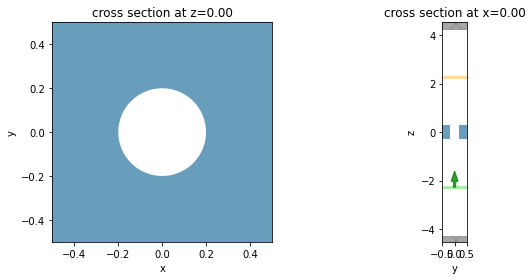

In [9]:
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
sim.plot(z=0., ax=ax[0]);
sim.plot(x=0, freq=freq0, ax=ax[1]);
plt.show()

We can also take a look at the source to make sure it's defined correctly over our frequency range of interst.

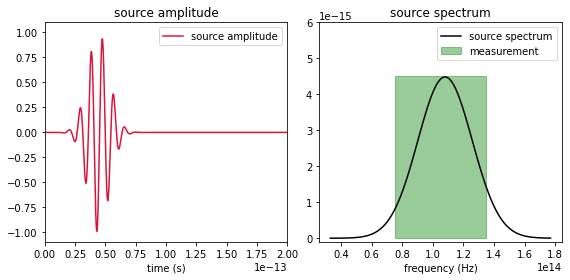

In [10]:
# Check probe and source
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
plot_time = 0.2e-12
ax1 = sim.sources[0].source_time.plot(times=np.linspace(0, plot_time, 1001), ax=ax1)
ax1.lines.pop(0)
ax1.lines.pop(1)
ax1.set_xlim(0, plot_time)
ax1.legend(('source amplitude',))
ax2 = sim.sources[0].source_time.plot_spectrum(times=np.linspace(0, sim.run_time, 10001), ax=ax2)
ax2.lines.pop(0)
ax2.lines.pop(0)
fill_max = 45e-16
ymax = 60e-16
ax2.fill_between(freq_range, [-0e-16, -0e-16], [fill_max, fill_max], alpha=0.4, color='g')
ax2.legend(('source spectrum', 'measurement'))
ax2.set_ylim(-1e-16, ymax)
plt.show()

Finally, we define a simulation object without PhC slab to normalize transmission. 

In [11]:
sim0 = sim.copy(deep=True)
sim0.structures=[]

## Running simulation

We will submit the simulation to run as a new project.

In [12]:
sim_data0 = web.run(sim0, task_name='PhC_normalization', path=f'data/sim_data0_run{runtime}_PML{dPML}.hdf5', normalize_index=None)
sim_data = web.run(sim, task_name='PhC_transmission', path=f'data/sim_data_run{runtime}_PML{dPML}.hdf5', normalize_index=None)

[09:25:40] INFO     Using Tidy3D credentials from stored file                      ]8;id=892644;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=387020;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#74\74]8;;\

[09:25:42] INFO     Uploaded task 'PhC_normalization' with task_id              ]8;id=549033;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=586714;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    '0b6eec29-3aaa-4baf-a433-7fdfc31b0fc4'.

[09:25:44] INFO     Maximum flex unit cost: 0.20                                ]8;id=338397;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=975524;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#141\141]8;;\

Output()

[09:25:53] INFO     status = preprocess                                         ]8;id=603370;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=863292;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[09:26:07] INFO     starting up solver                                          ]8;id=995451;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=202149;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#267\267]8;;\

[09:26:25] INFO     running solver                                              ]8;id=166738;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=667921;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#272\272]8;;\

Output()

[09:26:29] INFO     early shutoff detected, exiting.                            ]8;id=418797;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=461884;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#282\282]8;;\

% done (field decay = 1.58e-13) ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   4% -:--:--

Output()

[09:26:33] INFO     status = postprocess                                        ]8;id=506728;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=54794;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[09:26:39] INFO     status = success                                            ]8;id=729947;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=238821;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#296\296]8;;\

[09:26:41] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=754916;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=269393;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#522\522]8;;\
                    "data/sim_data0_run100.0_PML1.0.hdf5"

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

           INFO     loading SimulationData from                                 ]8;id=90430;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=971315;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\
                    data/sim_data0_run100.0_PML1.0.hdf5

[09:26:44] INFO     Uploaded task 'PhC_transmission' with task_id               ]8;id=459417;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=440688;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    '461e40fa-05af-4406-9927-23745245ec78'.

[09:26:45] INFO     Maximum flex unit cost: 0.20                                ]8;id=925919;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=921094;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#141\141]8;;\

Output()

[09:26:53] INFO     status = preprocess                                         ]8;id=691484;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=979830;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[09:27:13] INFO     starting up solver                                          ]8;id=787375;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=403821;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#267\267]8;;\

[09:27:59] INFO     running solver                                              ]8;id=987110;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=699863;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#272\272]8;;\

Output()

% done ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Output()

[09:28:03] INFO     status = postprocess                                        ]8;id=70897;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=774474;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[09:28:18] INFO     status = success                                            ]8;id=260732;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=82161;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#296\296]8;;\

[09:28:19] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=471167;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=423635;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#522\522]8;;\
                    "data/sim_data_run100.0_PML1.0.hdf5"

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

[09:28:22] INFO     loading SimulationData from                                 ]8;id=570564;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=623184;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\
                    data/sim_data_run100.0_PML1.0.hdf5

           WARNING  Simulation final field decay value of 1.62e-07 is greater   ]8;id=414996;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=87820;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#364\364]8;;\
                    than the simulation shutoff threshold of 1e-07. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.

## Post Run Analysis

Once the simulation has completed, we can download the results and load them into the simulation object.

Now, we compute the transmitted flux and plot the transmission spectrum.

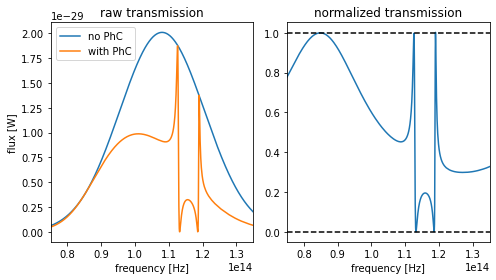

In [13]:
# Retrieve the power flux through the monitor plane.

transmission0 = sim_data0['flux']
transmission = sim_data['flux']
transmission_normalized = transmission / transmission0

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), tight_layout=True)
transmission0.plot(ax=ax1, label='no PhC')
transmission.plot(ax=ax1, label='with PhC')
ax1.set_xlim((freq_range[0],freq_range[1]))
transmission_normalized.plot(ax=ax2)
ax2.hlines(1.0,freq_range[0],freq_range[1],linestyles='dashed',color='black')
ax2.hlines(0.0,freq_range[0],freq_range[1],linestyles='dashed',color='black')
ax2.set_xlim((freq_range[0],freq_range[1]))
ax1.legend()
ax1.set_title('raw transmission')
ax2.set_title('normalized transmission')
plt.show()

To compare to the results in Fig.2 of the [paper](https://opg.optica.org/josaa/abstract.cfm?uri=josaa-20-3-569), let's plot the transmission as a function of frequency in the unit of c/period

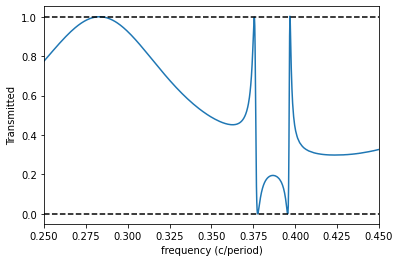

In [14]:
plt.figure()
plt.plot(monitor_freqs*period/td.C_0, transmission_normalized, label='normalized transmission')
plt.xlabel('frequency (c/period)')
plt.xlim([0.25, 0.45])
plt.hlines(1.0,0.25,0.45,linestyles='dashed',color='black')
plt.hlines(0.0,0.25,0.45,linestyles='dashed',color='black')
plt.ylabel('Transmitted')
plt.show()

Finally, we look into the time evolution of Ex at the center of the flux monitor.

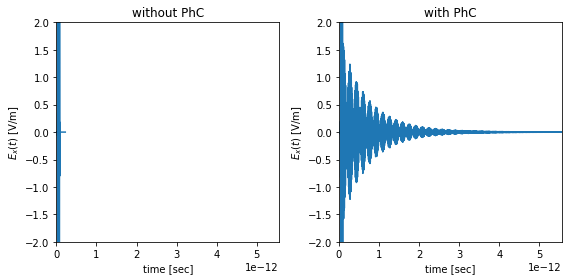

In [15]:
time_data = sim_data['time']
time_data0 = sim_data0['time']
fig, ax = plt.subplots(1,2,figsize=(8, 4), tight_layout=True)
ylim = 2
xlim = t_stop
# with PhC
Ex = time_data.Ex.interp(x=0, y=0, z=Lz/2 - spacing/2)
Ex.plot(ax=ax[1])
ax[1].set_ylim([-ylim,ylim])
ax[1].set_xlim([0,xlim])
ax[1].set_ylabel('$E_x(t)$ [V/m]')
ax[1].set_title('with PhC')
# without PhC
Ex0 = time_data0.Ex.interp(x=0, y=0, z=Lz/2 - spacing/2)
Ex0.plot(ax=ax[0])
ax[0].set_ylabel('$E_x(t)$ [V/m]')
ax[0].set_xlim([0,xlim])
ax[0].set_ylim([-ylim,ylim])
ax[0].set_title('without PhC')

plt.show()

Without PhC, the field decays rapidly; with PhC, a long detail tail is clearly visible.